# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision


## Homework 3 - Segmentation and Homographies
---

### <a style='color:red'> Due Date: 08.01.2025 </a>

### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
#### READ THIS CAREFULLY
* Submission only in **pairs**.
* **No handwritten submissions**.
* You can choose your working environment:
    * You can work in a `Jupyter Notebook`, locally with <a href="https://www.anaconda.com/distribution/">Anaconda</a> or online on <a href="https://colab.research.google.com/">Google Colab</a>
  * **Important**: Colab also supports running code on GPU, so if you don't have one, Colab is the way to go. To enable GPU on Colab, in the menu: `Runtime` $\rightarrow$  `Change Runtime Type` $\rightarrow$`GPU`.
    * You can work in a Python IDE such as <a href="https://www.jetbrains.com/pycharm/">PyCharm</a> or <a href="https://code.visualstudio.com/">Visual Studio Code</a>.
        * Both also allow opening/editing Jupyter Notebooks.

* Make sure you submit your exercise according to the requirements in the <a href="https://moodle.technion.ac.il/pluginfile.php/1823033/mod_resource/content/2/Homework%20guidelines.pdf">"Homework submission guidelines"</a> file that appears in the course website (Moodle). 
* **The code should run both on CPU and GPU without manual modifications**, require no special preparation and run on every computer.
* Be precise, we expect on point answers.
* Submission on the course website (Moodle).
* Bonuses are up to 10 points total (together). Maximum grade for submission is 105.

### <img src="https://img.icons8.com/dusk/64/000000/python.png" style="height:50px;display:inline"> Python Libraries
---

* `numpy`
* `matplotlib`
* `pytorch` (and `torchvision`)
* `opencv` (or `scikit-image`)
* `scikit-learn`
* Anything else you need (`PIL`, `os`, `pandas`, `csv`, `json`,...)

### Quick note
in this task, you will be required to use Deep learning segmentation methods. for that, you can use any method that has been presented in class, including but not limited to SegmentAnything,Mask-RCNN, and more.
if you choose SegmentAnything, use the following link to see an example for usage: <a href="https://github.com/facebookresearch/segment-anything">link here</a>. Note: if you use SAM, you must in order to use it, download pre-trained weights. please note in the report which model-type you chose, the link to the download. DO NOT include the pre-traiend weights

#### Installing segment-anything package:

In [18]:
! pip install git+https://github.com/facebookresearch/segment-anything.git 

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/b1/6p4sk8f166d1j8xr27c9vfxm0000gp/T/pip-req-build-m1390zsz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/b1/6p4sk8f166d1j8xr27c9vfxm0000gp/T/pip-req-build-m1390zsz
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [39]:
### imports
import os
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import PIL as Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import segment_anything as sa

In [40]:
### general device and path for universal use

if os.getcwd().split('/')[-1] == 'code':
    data_path = '../data/'
else:
    data_path = 'data/'

if torch.cuda.is_available():
    device = torch.device('cuda')
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: cpu


### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Tasks
---
* In all tasks, you should document your process and results in a report file (which will be saved as `.pdf`). 
* You can reference your code in the report file, but no need for actual code in this file, the code is submitted in a seprate folder as explained above.

#### Part 1 - Classic Vs. Deep Learning-based Semantic Segmentation - bonus
---
In this part you are going to compare classic methods for segmentation to deep learning-based methods. 

1. Load the images in the `./data/frogs` and `./data/horses` folders and display them.

In [41]:
# load images
frog_img_names = os.listdir(data_path + 'frogs/')
frog_imgs = [cv2.imread(data_path + 'frogs/' + img_name) for img_name in frog_img_names]
print(f"Loaded {len(frog_imgs)} frog images")

horse_img_names = os.listdir(data_path + 'horses/')
horse_imgs = [cv2.imread(data_path + 'horses/' + img_name) for img_name in horse_img_names]
print(f"Loaded {len(horse_imgs)} horse images")

Loaded 2 frog images
Loaded 2 horse images


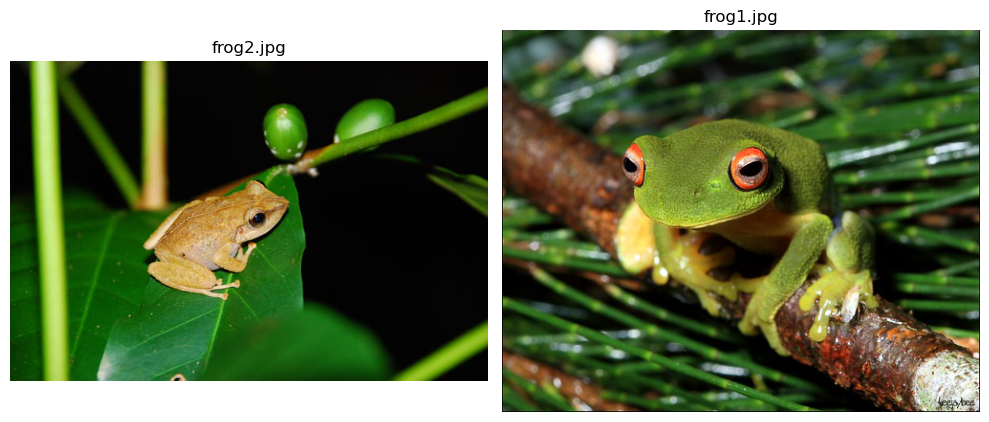

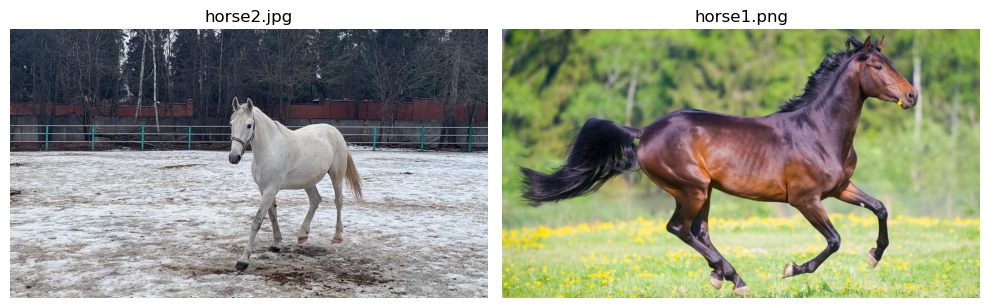

In [42]:
def display_images(images, names, rows=1):
    fig, axs = plt.subplots(rows, len(images) // rows, figsize=(5*len(images) // rows, 5*rows))
    axs = axs.flatten()
    for img, name, ax in zip(images, names, axs):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title(name)
    plt.tight_layout()
    plt.show()

display_images(frog_imgs, frog_img_names, rows=1)
display_images(horse_imgs, horse_img_names, rows=1)

2. Pick 1 classic method for segmentation and 1 deep learning-based method and segment the given images. Display the results.
    * **Briefly** summarize each method you picked and discuss the advantages and disadvantages of each method. In your answer, relate to the results you received in this section.
    * You can use a ready implementation from the internet or OpenCV, no need to implement it yourselves.
    * Note: the classic method **must not** use any neural network.

3. Pick 3 images (download from the internet or take them yourself) that satisfy the following, and dispaly them:
    * One image of a living being (human, animal,...).
    * One image of commonly-used object (car, chair, smartphone, glasses,...).
    * One image of not-so-commonly-used object (fire extinguisher, satellite,... **BE CREATIVE**).

4. Apply each method (one classic and one deep learning-based) on the 3 images. Display the results (mask and segmented image).
    * Which method performed better on each image? Describe your thoughts on why one method is better than the other.
    * For the classic method you can change parameters per-image, document them in the report.
    * You can add manual post-processing to get a mask if needed. If you do that, document in your report "how hard" you had to work in the post-processing stage, as it's an indication of the quality of the method.

5. As you probably have noticed, segmentation can be rough around the edges, i.e., the mask is not perfect and may be noisy around the edges. What can be done to fix or at least alleviate this problem? Your suggestions can be in pre-processing, inside the segmentation algorithm or in post-processing.

#### Part 2 - Jurrasic Fishbach - bonus
---
In this part you are going to apply segmentation on a video, and integrate with other elements.

<img src="https://lh3.googleusercontent.com/5zF16wl-tdE1FZCuVsrNxHWzfa6uXo4hYE_BGabKnGovw2W-bIT9gnZlAgU8nUoK=w412-h220-rw">

1. Film a short video of yourself (you can use your phone for that), but without too much camera movement. You on the other hand, can move however you want (we expect you to). Convert the video to frames and resize the images for a reasonable not too high resolution (lower than 720p ~ 1280x720 pixles). You can use the function in `./code/frame_video_convert.py` to help you. Display 2 frames in the report.
2. Segment yourself out of the video (frame-by-frame) using one of the methods (classic or deep). Display 2 frames in the report. 
3. Pick one of the objects in the supplied videos file (`./data/video_models`), convert it to images and segement it out using one of the methods from Part 1(classic or deep). Display 2 frames in the report. You can choose another object from: https://pixabay.com/videos/search/green%20screen/.
    * Explain how you performed the sementation for this specific type of video (i.e., green-screen videos). Did you  use a simple/classic method? Deep method? Combined both?
4. Put it all together - pick a background, put yourself and the segemented object on the background. Stich it frame-by-frame (don't make the video too long or it will take a lot of time, 10secs maximum). Display 2 frames of the result in your report. Convert the frames back to video. You can use the function in `frame_video_convert.py` to help you.
    * Tip: To make it look good, you can resize the images, create a mapping from pixel locations in the original image to pixels locations in the new image.
    * You should submit the final video in the `./output` folder (**MANDATORY**).
    * We expect some creative results, this can benefit you a lot when you want to demonstrate your Computer Vision abilities.


#### Part 3 - Planar Homographies - mandatory :
---
After we saw how descriptors are implemented and performed, now we will see how to use them for homographis.

In this part you will implement an image stitching algorithm, and will learn how to stitch several images of the same scene into a panorama. First, we’ll concentrate on the case of two images and then extend to several images.

For the following tasks:
- **You are not allowed to use OpenCV/Scipy or any other "ready to use" functions when you are asked to implement a function (you can still use the functions to save and load images).**
- For each step add illustration images to your report.
- You can demonstrate your steps using `incline_L.jpg` and `incline_R.jpg` images, or any other relevant example images (unless specified otherwise).

#### Planar Homographies: Theory review
---
Suppose we have two cameras $C_1$ and $C_2$ looking at a common plane $Π$ in 3D space. Any 3D point $P$ on $Π$ generates a projected 2D point located at $p ≡ (x,y,1)^T$ on the ﬁrst camera $C_1$ and $q ≡ (u,v,1)^T$ on the second camera $C_2$. Since $P$ is conﬁned to the plane $Π$, we expect that there is a relationship between $p$ and $q$. In particular, there exists a common $3 × 3$ matrix $H$, so that for any $P$, the following conditions holds: 
\begin{align}
\text{(1) }q ≡ Hp
\end{align}



We call this relationship *'planar homography'*. Recall that both $p$ and $q$ are in homogeneous coordinates and the equality $≡$ means $p$ is proportional to $Hq$ (recall homogeneous coordinates). It turns out this relationship is also true for cameras that are related by pure rotation without the planar constraint. 

##### **Matched points:**
---

Given a set of points $p = \{p_1,p_2,...,p_N\}$ in an image taken by camera $C_1$ and corresponding points $q = \{q_1,q_2,...,q_N\}$ in an image taken by $C_2$. Suppose we know there exists an unknown homography $H$ between corresponding points for all $i ∈\{1,2,...,N\}$. This formally means that $\exists H$ such that: 

 
\begin{equation*} 
\text{(2) } q^i ≡ Hp^i
\end{equation*}


where $p^i = (x_i,y_i,1)$ and $q^i = (u_i,v_i,1)$ are homogeneous coordinates of image points each from an image taken with $C_1$ and $C_2$ respectively.

* Given $N$ correspondences in $p$ and $q$ and using Equation 2, we derived a set of $2N$ independent linear equations in the form:


\begin{equation*} 
\text{(3) } Ah = 0
\end{equation*}


where $h$ is a vector of the elements of $H$ and $A$ is a matrix composed of elements derived from the point coordinates:  

$$ \begin{bmatrix} &&&&&\dots\\ x_i & y_i & 1 & 0 & 0 & 0 & -x_iu_i&-y_iu_i& -u_i \\ 0&0&0&x_i&y_i&1 & -x_iv_i&-y_iv_i& -v_i \\ &&&&&\dots \end{bmatrix} 
\begin{bmatrix} h_1\\h_2\\h_3\\ h_4 \\ h_5 \\ h_6 \\ h_7\\h_8\\h_9\\ \end{bmatrix} = \begin{bmatrix} \dots \\ 0 \\ 0  \\ \dots \end{bmatrix}$$


Each point pair contributes 2 equations and therefore we need at least 4 matches.

#### Planar Homographies: Practice 
---

#### Quick detour- Feature Descriptor
---
In this part we are going to use **Scale-Invariant Feature Transform** (SIFT). We will use OpenCV <a href="https://docs.opencv.org/3.4/db/d27/tutorial_py_table_of_contents_feature2d.html">[2]</a> for the implementation.

##### 3.0.1 SIFT Implementaion
---
Implement the following function:


In [43]:
def SIFT_descriptor(img):
    # Returns the SIFT descriptor keypoints of an image,and draw its detected keypoints
    # INPUTS
    #      img                 - An image read by cv2.imread(), greyscale
    # OUTPUTS
    #      sift_descriptor     - The SIFT descrptor computed by OpenCV
    #      sift_keypoints      - The SIFT keypoints computed by OpenCV
    sift = cv2.xfeatures2d.SIFT_create()
    sift_keypoints, sift_descriptor = sift.detectAndCompute(img, None)

    return sift_keypoints, sift_descriptor

The function get an image ,returns its SIFT descriptor and keypoints, and draw the detected keypoints over the image.

Plot the results obtained for the `model_chickenbroth` image and another `chickenbroth` image (Use the same image from previous section).


* Implementaton guidance:
    * Use `sift = cv2.xfeatures2d.SIFT_create()` to instantiate the SIFT detector. 
    * Detect and compute SIFT keypoints and descriptors by `sift_keypoint, sift_descriptor = sift.detectAndCompute(img,None)`.
    * Draw the keypoints over the image by using `cv2.drawKeypoints()`.


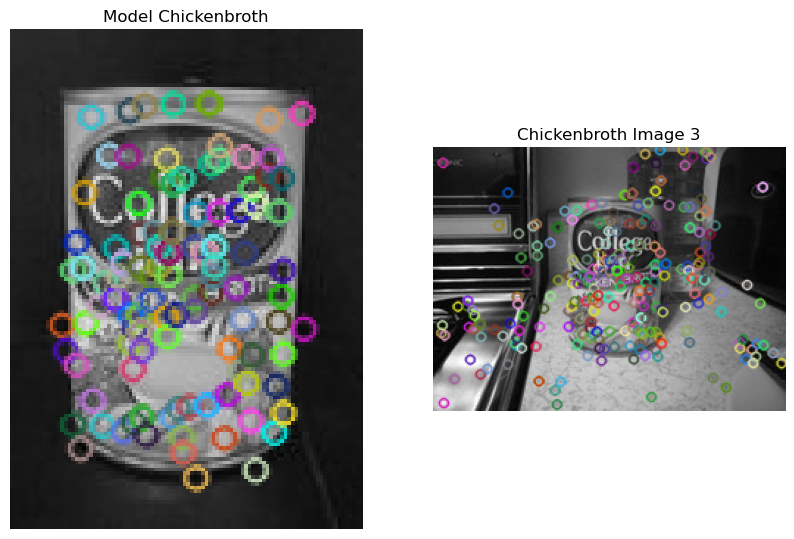

In [44]:
# Load images
cb_model_img = cv2.imread(data_path + 'my_data/model_chickenbroth.jpg', cv2.IMREAD_GRAYSCALE)
cb3_img = cv2.imread(data_path + 'my_data/chickenbroth_03.jpg', cv2.IMREAD_GRAYSCALE)

# Compute SIFT keypoints and descriptors
cb_model_keypoints, cb_model_descriptor = SIFT_descriptor(cb_model_img)
cb3_keypoints, cb3_descriptor = SIFT_descriptor(cb3_img)

# Compute kepoints
cb_model_img_kp = cv2.drawKeypoints(cb_model_img, cb_model_keypoints, None)
cb3_img_kp = cv2.drawKeypoints(cb3_img, cb3_keypoints, None)

# Display images
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(cb_model_img_kp)
plt.title('Model Chickenbroth')
plt.axis('off')

plt.subplot(122)
plt.imshow(cb3_img_kp)
plt.title('Chickenbroth Image 3')
plt.axis('off')

plt.show()


##### 3.1 - Finding corresponding points using SIFT: 
---
Use the guidelines from 3.0.1 and implement the function `getPoints_SIFT()`, which gets two images and outputs `p1,p2` SIFT keypoints, where `p1[j],p2[j]` are pairs of cooresponding points between `im1` and `im2`.

In [45]:
def is_point_in_img(p, img):
    return 0 <= p[0] < img.shape[1] and 0 <= p[1] < img.shape[0]

def getPoints_SIFT(im1, im2):
    # Returns the keypoints of two images and their descriptors
    # INPUTS
    #      im1                 - An image read by cv2.imread(), greyscale
    #      im2                 - An image read by cv2.imread(), greyscale
    # OUTPUTS
    #      p1                  - The keypoints of im1
    #      p2                  - The keypoints of im2

    # Compute SIFT keypoints and descriptors
    k1, d1 = SIFT_descriptor(im1)
    k2, d2 = SIFT_descriptor(im2)

    # Create a BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(d1, d2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Get the points ordered by the matches
    p1 = np.array([k1[m.queryIdx].pt for m in matches])
    p2 = np.array([k2[m.trainIdx].pt for m in matches])

    return p1,p2

Inputs: `im1` and `im2` are two 2D grayscale images. 

Output: `p1` and `p2` should be $2\times N$ matrices of corresponding $(x,y)^T$ coordinates between two images ($N$ is the number of corrosponding points you want to extract.). 

* You can also use color images instead of grayscale images, just state it in the report.

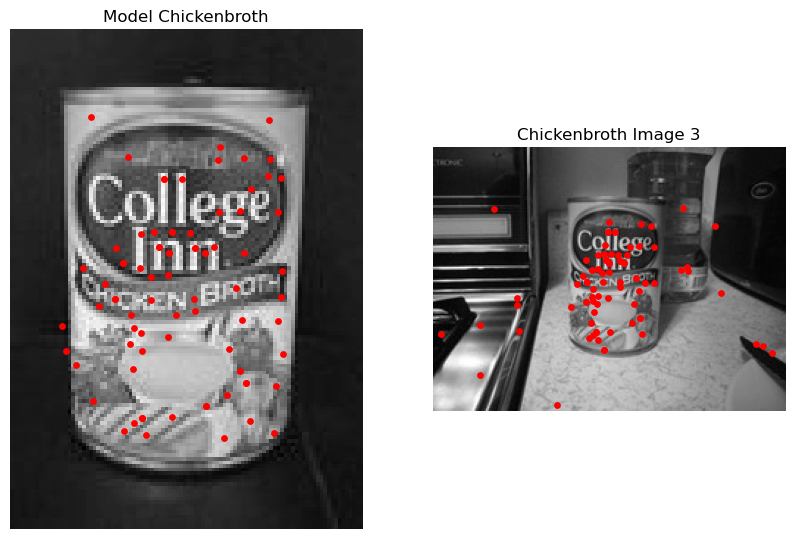

In [46]:
p1, p2 = getPoints_SIFT(cb_model_img, cb3_img)

# Display the matches
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(cb_model_img, cmap='gray')
plt.title('Model Chickenbroth')
plt.scatter(p1[:, 0], p1[:, 1], c='r', s=15)
plt.axis('off')

plt.subplot(122)
plt.imshow(cb3_img, cmap='gray')
plt.title('Chickenbroth Image 3')
plt.scatter(p2[:, 0], p2[:, 1], c='r', s=15)
plt.axis('off')

plt.show()


#### 3.2 - Calculate transformation: 
---

Implement a function that gets a set of matching points between two images and calculates the transformation between them. The transformation should be $3\times3$ $H$ homogenous matrix such that for each point in image $p\in C_1$, there would be a transformation in image $C_2$ such that $p=Hq$, $q\in C_2$.

In [79]:
def computeH(p1, p2):
    # Returns the homography matrix H that transforms points from p2 to p1: holds p1 = H*p2
    # INPUTS
    #      p1                  - The keypoints of the first image
    #      p2                  - The keypoints of the second image
    # OUTPUTS
    #      H                   - The homography matrix

    # norm_p1 = p1 / np.max(p1)
    # norm_p2 = p2 / np.max(p2)

    # Create a matrix A from the data points
    A = np.zeros((2 * p1.shape[0], 9))
    for i in range(p1.shape[0]):
        x1, y1 = p1[i]
        x2, y2 = p2[i]
        A[2 * i] = np.array([x1, y1, 1, 0, 0, 0, -x1 * x2, -y1 * x2, -x2])
        A[2 * i + 1] = np.array([0, 0, 0, x1, y1, 1, -x1 * y2, -y1 * y2, -y2])
        
    # Compute the SVD of A
    U, S, V = np.linalg.svd(A)

    # Get the homography matrix
    H2to1 = V[-1].reshape(3, 3)
    # normalize H
    H2to1 = H2to1 / H2to1[2, 2]

    return H2to1

Inputs: `p1` and `p2` should be $2\times N$ matrices of corresponding $(x,y)^T$ coordinates between two images. 

Outputs: `H2to1` should be a $3\times 3$ matrix encoding the homography that best matches the linear equation derived above for Equation 2. 

Hint: Remember that a homography is only determined up to scale. The `numpy`'s functions `eig()` or `svd()` will be useful. Note that this function can be written without an explicit for-loop over the data points.

*Hint for debugging*: A good test of your code is to check that the homography of an image with itself is an identity.

* Implement the computation function, describe and explain your implementation.

In [80]:
p1, p2 = getPoints_SIFT(cb_model_img, cb_model_img)
# p1 = p1[:500]
# p2 = p2[:500]
H2to1 = computeH(p1, p2)
H1to2 = computeH(p2, p1)
print(f'The homography matrix 2 to 1 is:\n{H2to1.round(2)}')
print(f'The homography matrix 1 to 2 is:\n{H1to2.round(2)}') 

The homography matrix 2 to 1 is:
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0. -0.  1.]]
The homography matrix 1 to 2 is:
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0. -0.  1.]]


* Show that the transformation is correct by selecting arbitrary points in the first image and projecting them to the second image.

In [75]:
# Compute Incline images
inclineR_img = cv2.imread(data_path + 'incline_R.png', cv2.IMREAD_GRAYSCALE)
inclineL_img = cv2.imread(data_path + 'incline_L.png', cv2.IMREAD_GRAYSCALE)

# Compute SIFT keypoints and descriptors
p1, p2 = getPoints_SIFT(inclineR_img, inclineL_img)

# Save only top N matches
N = 500
p1, p2 = p1[:N], p2[:N]

# Compute the homography matrix
H2to1 = computeH(p1, p2)
H1to2 = computeH(p2, p1)

# Project the images and return to 2D space
p1_project = H2to1 @ np.hstack((p1, np.ones((p1.shape[0], 1)))).T
p1_project = p1_project / p1_project[-1]
p1_project = p1_project[:2].T.astype(int)
p1_project = np.array([p for p in p1_project if is_point_in_img(p, inclineL_img)])

p2_project = H1to2 @ np.hstack((p2, np.ones((p2.shape[0], 1)))).T
p2_project = p2_project / p2_project[-1]
p2_project = p2_project[:2].T.astype(int)
p2_project = np.array([p for p in p2_project if is_point_in_img(p, inclineR_img)])

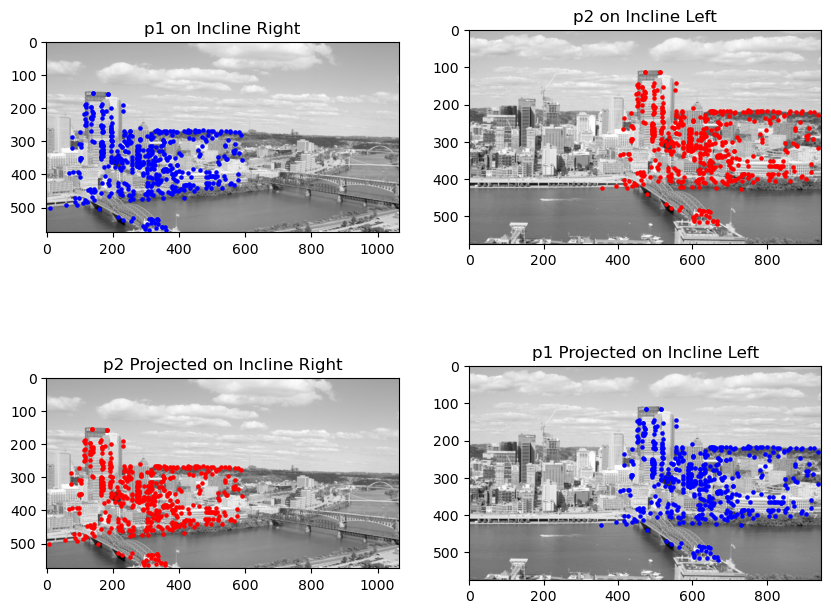

In [76]:
# Display 4x4 plot of points on original and projected images
plt.figure(figsize=(10, 8))

plt.subplot(221)
plt.imshow(inclineR_img, cmap='gray')
plt.scatter(p1[:, 0], p1[:, 1], c='b', s=5)
plt.title('p1 on Incline Right')

plt.subplot(222)
plt.imshow(inclineL_img, cmap='gray')
plt.scatter(p2[:, 0], p2[:, 1], c='r', s=5)
plt.title('p2 on Incline Left')

plt.subplot(223)
plt.imshow(inclineR_img, cmap='gray')
plt.scatter(p2_project[:, 0], p2_project[:, 1], c='r', s=5)
plt.title('p2 Projected on Incline Right')

plt.subplot(224)
plt.imshow(inclineL_img, cmap='gray')
plt.scatter(p1_project[:, 0], p1_project[:, 1], c='b', s=5)
plt.title('p1 Projected on Incline Left')

plt.show()

The projection appears to be relatively accurate, with many points matching between the original image (top row) and the relevant projected points (bottom row).

#### 3.3 - Image warping:
---
Implement a function that gets an input image and a transformation matrix H and returns the warped image. Please note that after the warping, there will be coordinates that won’t be integers (e.g. sub-pixels). Therefore you will need to interpolate between neighboring pixels. For color images, warp the image for each color channel and then connect them together. In order to avoid holes, use inverse warping.

Implement the wrapping function using numpy and SciPy interp2d() or RegularGridInterpolator() function .
Discuss the influences of different interpolations kinds {‘linear’, ‘cubic’}.
Note: When performing a multi-step algorithm, you need to demonstrate and explain each of those additional improvments.


In [101]:
from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator

def computeOutputSize(H, im1_size, im2_size):
    # Returns the output size of the warped image
    # INPUTS
    #      H                   - The homography matrix
    #      im1_size            - The size of the first image
    #      im2_size            - The size of the second image
    # OUTPUTS
    #      out_size            - The size of the output image

    # Compute the corners of the input image
    corners = np.array([[0, 0, 1], 
                        [0, im1_size[1], 1], 
                        [im1_size[0], 0, 1], 
                        [im1_size[0], im1_size[1], 1]])
    corners_project = H @ corners.T
    corners_project = corners_project / corners_project[-1]
    corners_project = corners_project[:2].T.astype(int)

    # Compute the new bounds on the output image
    min_r, max_r = np.min(corners_project[:, 0]), np.max(corners_project[:, 0])
    min_c, max_c = np.min(corners_project[:, 1]), np.max(corners_project[:, 1])
    out_size = (int(max_r - min_r + 1), int(max_c - min_c + 1))

    # Update the homography and shifts
    trans_mat = np.array([[1, 0, -min_r],
                          [0, 1, -min_c],
                          [0, 0, 1]])
    H = trans_mat @ H
    
    return out_size, H

def warpH(im1, H, out_size, method='linear'):

    # Compute input image dimensions
    if im1.ndim == 2:
        # Grayscale input => make it (H_in, W_in, 1)
        H_in, W_in = im1.shape
        C = 1
        im1 = im1[..., np.newaxis]
    else:
        H_in, W_in, C = im1.shape

    # Compute output image dimensions
    out_h, out_w = out_size
    warped_im = np.zeros((out_h, out_w, C), dtype=im1.dtype)

    # Invert the homography matrix
    H_inv = np.linalg.inv(H)

    #  Create the grid for the output image
    row_coords = np.arange(out_h)
    col_coords = np.arange(out_w)
    rr, cc = np.meshgrid(row_coords, col_coords, indexing='ij')
    rr_flat, cc_flat = rr.flatten(), cc.flatten()
    out_points_hom = np.stack([rr_flat, cc_flat, np.ones_like(rr_flat)], axis=0)  # Shape = (3, N)

    # Map each point in the output image to the input image
    in_points_hom = H_inv @ out_points_hom
    in_points_hom = in_points_hom / in_points_hom[-1] # From homogenous to heterogenous coordinates
    in_points = in_points_hom[:2]

    in_points_x = in_points[0, :].reshape((out_h, out_w))
    in_points_y = in_points[1, :].reshape((out_h, out_w))
    
    # Wrap the image in each color channel
    row_grid = np.arange(H_in)
    col_grid = np.arange(W_in)

    for c in range(C):
        # Interpolate the image
        rgi = RegularGridInterpolator((row_grid, col_grid), im1[:, :, c], 
                                      method=method, bounds_error=False, fill_value=0)
        warped_channel = rgi(np.stack([in_points_x, in_points_y], axis=-1))
        warped_im[:, :, c] = warped_channel.reshape((out_h, out_w))

    return warped_im


Inputs: `im1` is a colored image. `H` is a  matrix encoding the homography between im1 and im2. `out_size` is the size of the wanted output (new_imH,new_imW).

Output: `warp_im1` is the warped image im1 including empty background (zeros).

warped left image: (600, 1069, 3)
warped right image: (856, 1418, 3)


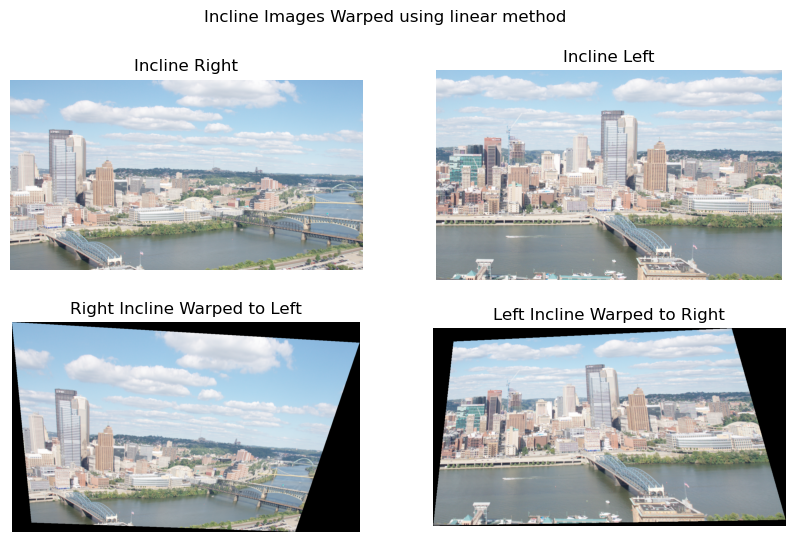

warped left image: (600, 1069, 3)
warped right image: (856, 1418, 3)


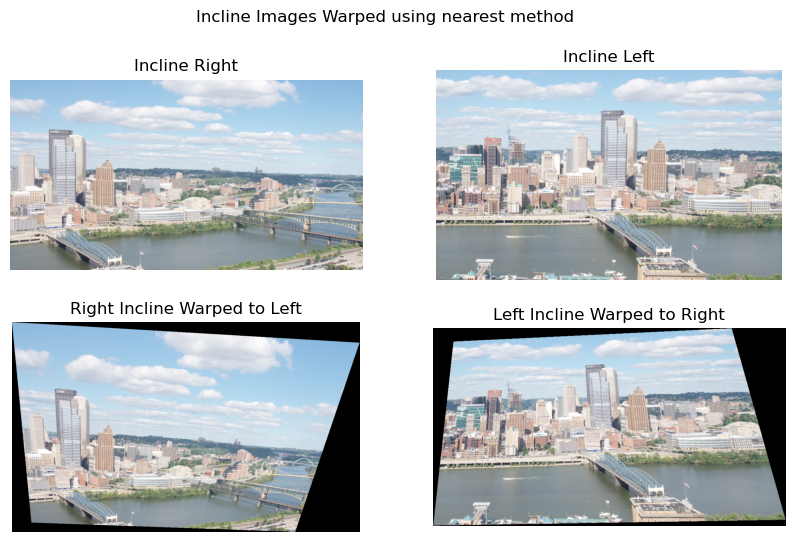

In [107]:
# Compute Incline images
inclineR_img = cv2.imread(data_path + 'incline_R.png')
inclineL_img = cv2.imread(data_path + 'incline_L.png')

# Compute SIFT keypoints and descriptors
p1, p2 = getPoints_SIFT(inclineR_img, inclineL_img)
N = 500
p1, p2 = p1[:N], p2[:N]
H_l2r = computeH(p1,p2)
H_r2l = computeH(p2,p1)

for method in ['linear', 'nearest']:

    # Warp the left image to the right image
    out_size_R, H_l2r = computeOutputSize(H_l2r, inclineL_img.shape, inclineR_img.shape)
    warped_im_L = warpH(inclineL_img, H_l2r, out_size_R, method=method)
    print("warped left image:", warped_im_L.shape)

    # Warp the right image to the left image
    out_size_L, H_r2l = computeOutputSize(H_r2l, inclineR_img.shape, inclineL_img.shape)
    warped_im_R = warpH(inclineR_img, H_r2l, out_size_L, method=method)
    print("warped right image:", warped_im_R.shape)

    # title for all subplots 
    plt.figure(figsize=(10, 6))
    plt.suptitle(f'Incline Images Warped using {method} method')

    plt.subplot(221)
    plt.imshow(cv2.cvtColor(inclineR_img, cv2.COLOR_BGR2RGB))
    plt.title('Incline Right')
    plt.axis('off')

    plt.subplot(222)
    plt.imshow(cv2.cvtColor(inclineL_img, cv2.COLOR_BGR2RGB))
    plt.title('Incline Left')
    plt.axis('off')

    plt.subplot(223)
    plt.imshow(cv2.cvtColor(warped_im_R.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title('Right Incline Warped to Left')
    plt.axis('off')

    plt.subplot(224)
    plt.imshow(cv2.cvtColor(warped_im_L.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title('Left Incline Warped to Right')
    plt.axis('off')

    plt.show()

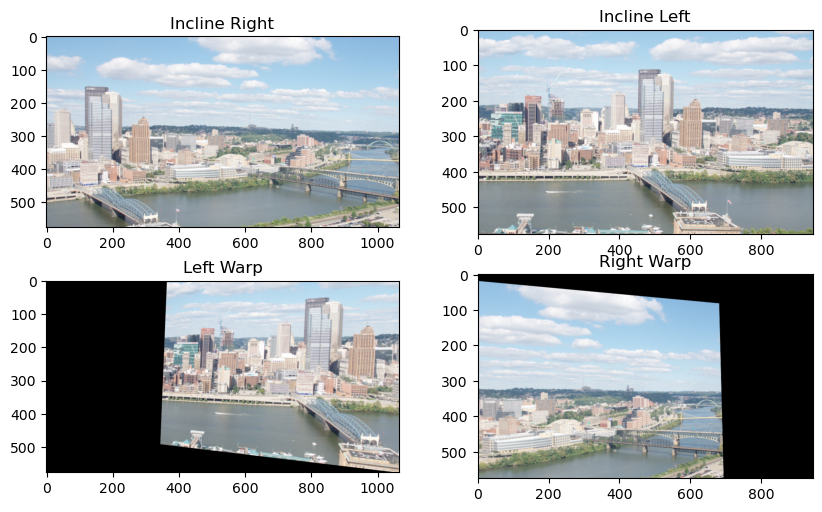

In [126]:
#### Test block = compare to cv2.warpPerspective

# Compute SIFT keypoints and descriptors
p1, p2 = getPoints_SIFT(inclineR_img, inclineL_img)
p1, p2 = p1[:300], p2[:300]
H_l2r = computeH(p1,p2)
H_r2l = computeH(p2,p1)

# warp using cv2's warpPerspective
warped_im_L = cv2.warpPerspective(inclineL_img, H_l2r, (inclineR_img.shape[1], inclineR_img.shape[0]))
warped_im_R = cv2.warpPerspective(inclineR_img, H_r2l, (inclineL_img.shape[1], inclineL_img.shape[0]))

# Display the images
plt.figure(figsize=(10, 9))
plt.subplot(321)
plt.imshow(cv2.cvtColor(inclineR_img, cv2.COLOR_BGR2RGB))
plt.title('Incline Right')

plt.subplot(322)
plt.imshow(cv2.cvtColor(inclineL_img, cv2.COLOR_BGR2RGB))
plt.title('Incline Left')

plt.subplot(324)
plt.imshow(cv2.cvtColor(warped_im_R, cv2.COLOR_BGR2RGB))
plt.title('Right Warp')

plt.subplot(323)
plt.imshow(cv2.cvtColor(warped_im_L, cv2.COLOR_BGR2RGB))
plt.title('Left Warp')

plt.show()

##### 3.4 - Panorama stitching: 
---
Implement a function that gets two images after axis alignment (using OpenCV's `warpPerspective`)
and returns a union of the two. The union should be a simple overlay of one image on the other. Leave empty pixels painted black.


In [154]:
def imageStitching(img1, warp_img2):
    # Returns the stitched image of two images
    # INPUTS
    #      img1                 - An image read by cv2.imread(), colored
    #      warp_img2            - The warped image
    # OUTPUTS
    #      panoImg           - The stitched image

    # Get dimensions for the output image
    height1, width1 = img1.shape[:2]
    height2, width2 = warp_img2.shape[:2]
    
    # Calculate the panorama canvas size
    # Ensure img2 is placed correctly in the panorama space
    pano_width = max(width1, width2)
    pano_height = max(height1, height2)
    
    # Create a blank canvas for the panorama
    panoImg = np.zeros((pano_height, pano_width, 3), dtype=np.uint8)
    
    # Place img1 onto the panorama canvas
    panoImg[:height1, :width1] = img1
    
    # Overlay img2 onto the canvas
    # For non-zero pixels in img2, overwrite the corresponding pixels in panoImg
    non_zero_indices = np.where(warp_img2 > 0)
    panoImg[non_zero_indices] = warp_img2[non_zero_indices]

    # Find the bounding box of non-black pixels
    non_black = np.where(panoImg.any(axis=2))
    if len(non_black[0]) == 0:  # If image is all black
        return panoImg
        
    row_min, row_max = np.min(non_black[0]), np.max(non_black[0])
    col_min, col_max = np.min(non_black[1]), np.max(non_black[1])
    
    # Crop the image to the bounding box
    panoImg = panoImg[row_min:row_max+1, col_min:col_max+1]
    
    return panoImg

In [129]:
# def imageStitching(img1, warp_img2):
#     # Returns the stitched image of two images
#     # INPUTS
#     #      img1                 - An image read by cv2.imread(), colored
#     #      warp_img2            - The warped image
#     # OUTPUTS
#     #      panoImg           - The stitched image

#     # Get dimensions for the output image
#     height1, width1 = img1.shape[:2]
#     height2, width2 = warp_img2.shape[:2]
    
#     # Find the minimum x-coordinate in warp_img2
#     non_zero = np.nonzero(warp_img2)
#     if len(non_zero[1]) == 0:  # If warp_img2 is all zeros
#         return img1
        
#     min_x = np.min(non_zero[1])
#     min_y = np.min(non_zero[0])
    
#     # Calculate offset for placing img1
#     offset_x = min_x if min_x < 0 else 0
#     offset_y = min_y if min_y < 0 else 0
    
#     # Calculate the panorama canvas size
#     pano_width = max(width1 + abs(offset_x), width2)
#     pano_height = max(height1 + abs(offset_y), height2)
    
#     # Create a blank canvas for the panorama
#     panoImg = np.zeros((pano_height, pano_width, 3), dtype=np.uint8)
    
#     # Place img1 onto the panorama canvas with the calculated offset
#     x_start = abs(offset_x)
#     y_start = abs(offset_y)
#     panoImg[y_start:y_start+height1, x_start:x_start+width1] = img1
    
#     # Overlay img2 onto the canvas
#     # For non-zero pixels in img2, overwrite the corresponding pixels in panoImg
#     non_zero_indices = np.where(warp_img2 > 0)
#     if len(non_zero_indices[0]) > 0:  # Check if there are any non-zero pixels
#         y_coords = non_zero_indices[0]
#         x_coords = non_zero_indices[1]
#         # Only copy pixels that fall within the panorama bounds
#         valid_indices = (x_coords >= 0) & (x_coords < pano_width)
#         y_coords = y_coords[valid_indices]
#         x_coords = x_coords[valid_indices]
#         panoImg[y_coords, x_coords] = warp_img2[y_coords, x_coords]
    
#     return panoImg

def imageStitching(img1, warp_img2):
    # Get dimensions for the output image
    height1, width1 = img1.shape[:2]
    height2, width2 = warp_img2.shape[:2]
    
    # Find where the actual content starts in warp_img2
    non_zero = np.nonzero(warp_img2)
    if len(non_zero[1]) == 0:  # If warp_img2 is all zeros
        return img1
        
    min_x = np.min(non_zero[1])
    
    # Place img1 at an offset if warp_img2's content starts early in the canvas
    # If min_x is small (e.g., < width1/3), it suggests warp_img2 is positioned to the left
    if min_x < width1/3:  # You might need to adjust this threshold
        x_start = width2 - width1
    else:
        x_start = 0
    
    # Create a blank canvas for the panorama
    pano_width = max(width1 + x_start, width2)
    pano_height = max(height1, height2)
    panoImg = np.zeros((pano_height, pano_width, 3), dtype=np.uint8)
    
    # Place img1 onto the panorama canvas with the calculated offset
    panoImg[:height1, x_start:x_start+width1] = img1
    
    # Overlay img2 onto the canvas
    non_zero_indices = np.where(warp_img2 > 0)
    if len(non_zero_indices[0]) > 0:
        y_coords = non_zero_indices[0]
        x_coords = non_zero_indices[1]
        # Only copy pixels that fall within the panorama bounds
        valid_indices = (x_coords < pano_width)
        y_coords = y_coords[valid_indices]
        x_coords = x_coords[valid_indices]
        panoImg[y_coords, x_coords] = warp_img2[y_coords, x_coords]
    
    return panoImg

Inputs: `im1`,`warp_img2` are two colored images. 

Output: `panoImg` is the gathered output  panorama.

* Use all the above functions to create a panorama image. Demonstrate and explain you results on the `./data/incline` images.

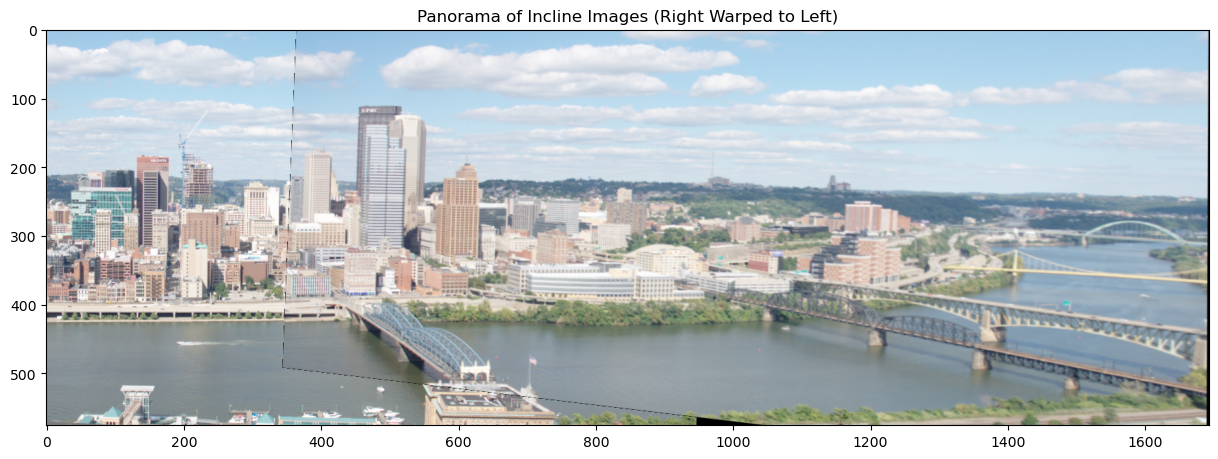

In [155]:
# Compute SIFT keypoints and descriptors
p1, p2 = getPoints_SIFT(inclineR_img, inclineL_img)

# Limit the number of points to 300 for consistency
p1, p2 = p1[:300], p2[:300]

# Compute homographies
H_l2r = computeH(p1, p2)  # From left to right
H_r2l = computeH(p2, p1)  # From right to left

# Warp the right image to the left image space
warped_im_R = cv2.warpPerspective(inclineR_img, H_l2r, 
                                   (inclineL_img.shape[1] + inclineR_img.shape[1], inclineL_img.shape[0]))
# Stitch the panorama (Left Image + Warped Right Image)
panorama_R = imageStitching(inclineL_img, warped_im_R)

# Display
plt.figure(figsize=(15, 7))
plt.imshow(cv2.cvtColor(panorama_R, cv2.COLOR_BGR2RGB))
plt.title('Panorama of Incline Images (Right Warped to Left)')
plt.show()


##### 3.5 - Several Images stitching:
---
* Show the results of the panoramas on the attached images of the beach (`./data/beach`) and Pena National Sintra Palace (`./data/sintra`) for the entire set of images.

* Note: When using SIFT without RANSAC (next section), take the top K matches for estimating the homography. 
  * What happens if you don't do so? Why is that?

##### 3.6 - RANSAC:
---
Added bellow is an implementation of the RANSAC (**Ran**dom **Sa**mple **C**onsensus) algorithm. 
* Explain when it is needed and why.
* Copmare between using RANSAC vs. not using it for creating the panoran images of the beach and SINTRA. Explain.
* What could have been done to get better results?

In [ ]:
def ransacH(p1, p2, nIter=..., tol=...):
    N = p1.shape[1]
    stacked_p2 = np.vstack((p2, np.ones(N)))

    best_inliers_n = 0
    best_inliers = []

    for iter in range(nIter):
        rand_idxs = np.random.choice(np.arange(N), 4, replace=False)
        chosen_p1 = p1[:, rand_idxs]
        chosen_p2 = p2[:, rand_idxs]
        H2to1 = computeH(chosen_p1, chosen_p2)
        p2in1 = H2to1 @ stacked_p2
        p2in1 = p2in1 / p2in1[2, :]
        p2in1 = p2in1[0:2, :]
        L2dists = np.sqrt(np.sum((p2in1 - p1) ** 2, 0))
        inliers = (p1[:, L2dists < tol], p2[:, L2dists < tol])
        n_inliers = np.sum(L2dists < tol)
        if n_inliers > best_inliers_n:
            best_inliers_n = n_inliers
            best_inliers = inliers

    bestH = computeH(best_inliers[0], best_inliers[1])
    return bestH

Inputs: 
* `p1` and `p2` are matrices specifying point locations in each of the images and `p1[j]`,`p2[j]` are matched points between two images.

* `nIter` is the number of iterations to run RANSAC  

* `tol` is the tolerance value for considering a point to be an inlier. 

 * Define your function so that these  `nIter` and  `tol` have reasonable default values.

Outputs: 
* `bestH` is the homography model with the most inliers found during RANSAC

##### 3.7 - Be Creative:
---
* Go out and take at least 3 pictures of a far distance object (e.g. a building), and use what you have learned to create a new excellent Panorama image.
  * Add the resulted image to your report and to the `output` folder.

---
## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
* Images from <a href="http://www.image-net.org/">Imagenet</a>
* Videos from <a href="https://pixabay.com/videos/search/green%20screen/">Pixabay</a>
    * Dinosaur video from <a href="https://sites.google.com/a/sau17.net/modern-media/home/green-screen-animations">Modern Media</a>
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com